In [1]:
import cv2
print("✅ cv2 version:", cv2.__version__)


✅ cv2 version: 4.10.0


In [2]:
import os
import numpy as np
import cv2
from glob import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

IMG_SIZE = 256
pixel_per_cm = 72

def load_data(image_dir, mask_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))
    images, masks = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        images.append(img)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
        masks.append(np.expand_dims(mask, axis=-1))
    return np.array(images), np.array(masks)

def conv_block(x, filters):
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(x, filters):
    s = conv_block(x, filters)
    p = MaxPooling2D((2, 2))(s)
    return s, p

def decoder_block(x, skip, filters):
    x = Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
    x = Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    return Model(inputs, outputs)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def calculate_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return intersection / (union + 1e-7)

def get_endpoint_y(mask):
    coords = np.argwhere(mask[..., 0] > 0.5)
    return np.max(coords[:, 0]) if len(coords) > 0 else None


In [3]:
def run_fold2():
    base_path = "ETT-v3/Fold2"
    x_train, y_train = load_data(os.path.join(base_path, "train"), os.path.join(base_path, "trainannot"))
    x_val, y_val = load_data(os.path.join(base_path, "val"), os.path.join(base_path, "valannot"))
    x_test, y_test = load_data(os.path.join(base_path, "test"), os.path.join(base_path, "testannot"))

    print(f"Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

    model = build_unet()
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("unet_fold2_best.h5", save_best_only=True)
    ]

    print("Start training...")
    model.fit(x_train, y_train,
              validation_data=(x_val, y_val),
              batch_size=8,
              epochs=30,
              callbacks=callbacks,
              verbose=1)

    print("Training completed. Start evaluation...")

    ious = []
    errors, acc_05cm, acc_10cm, valid = [], 0, 0, 0
    for i in range(len(x_test)):
        pred = model.predict(np.expand_dims(x_test[i], axis=0), verbose=0)[0]
        pred = (pred > 0.5).astype(np.uint8)

        ious.append(calculate_iou(y_test[i], pred))

        true_y = get_endpoint_y(y_test[i])
        pred_y = get_endpoint_y(pred)
        if true_y is not None and pred_y is not None:
            error_pixel = abs(pred_y - true_y)
            errors.append(error_pixel / pixel_per_cm)
            valid += 1
            if error_pixel <= 36:
                acc_05cm += 1
            if error_pixel <= 72:
                acc_10cm += 1

    print("Evaluation completed.")
    print("Fold2 Results:")
    print(f"Mean IOU: {np.mean(ious):.4f}")
    print(f"Mean Endpoint Error: {np.mean(errors):.2f} cm")
    print(f"Accuracy within 0.5 cm: {acc_05cm / valid:.2%}")
    print(f"Accuracy within 1.0 cm: {acc_10cm / valid:.2%}")


In [4]:
run_fold2()

Train: 287, Val: 47, Test: 47
Start training...
Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.5079 - loss: 0.9663 

36/36 ━━━━━━━━━━━━━━━━━━━━ 891s 24s/step - accuracy: 0.5124 - loss: 0.9659 - val_accuracy: 0.9922 - val_loss: 0.9854
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 841s 23s/step - accuracy: 0.9513 - loss: 0.8950 - val_accuracy: 0.9922 - val_loss: 0.9858
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 834s 23s/step - accuracy: 0.9767 - loss: 0.8564 - val_accuracy: 0.9922 - val_loss: 0.9870
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 832s 23s/step - accuracy: 0.9833 - loss: 0.8343 - val_accuracy: 0.9922 - val_loss: 0.9881
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 827s 23s/step - accuracy: 0.9855 - loss: 0.8172 - val_accuracy: 0.9922 - val_loss: 0.9878
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 826s 23s/step - accuracy: 0.9882 - loss: 0.7939 - val_accuracy: 0.9922 - val_loss: 0.9879
Training completed. Start evaluation...
Evaluation completed.
Fold2 Results:
Mean IOU: 0.0000
Mean Endpoint Error: 1.15 cm
Accuracy within 0.5 cm: 0.00%
Accuracy within 1.0 cm: 55.56%


In [5]:
import matplotlib.pyplot as plt

def visualize_prediction(index, x_test, y_test, model):
    image = x_test[index]
    true_mask = y_test[index]

    # 預測
    pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # 畫圖
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(true_mask[..., 0], cmap='viridis')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_mask[..., 0], cmap='viridis')
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.suptitle(f"Test Sample {index} - Fold2", fontsize=14)
    plt.tight_layout()
    plt.show()


In [6]:
visualize_prediction(0, x_test, y_test, model)

NameError: name 'x_test' is not defined

In [7]:
# 載入 Fold2 測試資料
x_test, y_test = load_data("ETT-v3/Fold2/test", "ETT-v3/Fold2/testannot")

# 載入最佳訓練模型權重（你之前有儲存為 .h5）
model = build_unet()
model.load_weights("unet_fold2_best.h5")

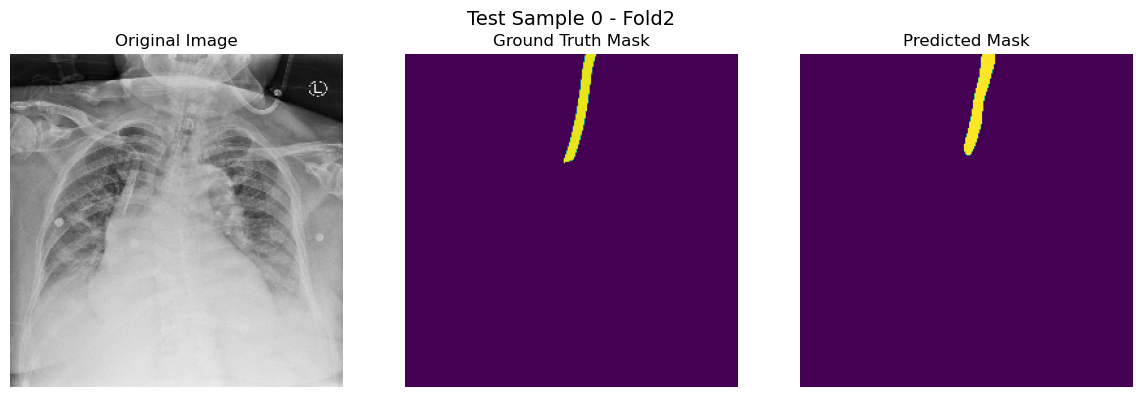

In [8]:
visualize_prediction(0, x_test, y_test, model)

In [9]:
def get_endpoint_coords(mask):
    coords = np.argwhere(mask[..., 0] > 0.5)
    if len(coords) == 0:
        return None
    return coords[np.argmax(coords[:, 0])]  # y 最大的點（最下方）

def visualize_with_endpoints(index, x_test, y_test, model):
    image = x_test[index]
    true_mask = y_test[index]

    # 預測遮罩
    pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # 找端點座標
    true_coord = get_endpoint_coords(true_mask)
    pred_coord = get_endpoint_coords(pred_mask)

    # 畫圖
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(true_mask[..., 0], cmap='viridis')
    if true_coord is not None:
        axs[1].plot(true_coord[1], true_coord[0], 'ro')
        axs[1].text(true_coord[1]+2, true_coord[0], 'G', color='red', fontsize=12)
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_mask[..., 0], cmap='viridis')
    if pred_coord is not None:
        axs[2].plot(pred_coord[1], pred_coord[0], 'ro')
        axs[2].text(pred_coord[1]+2, pred_coord[0], 'Y', color='red', fontsize=12)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.suptitle(f"Test Sample {index} - G: Ground Truth, Y: Prediction", fontsize=14)
    plt.tight_layout()
    plt.show()


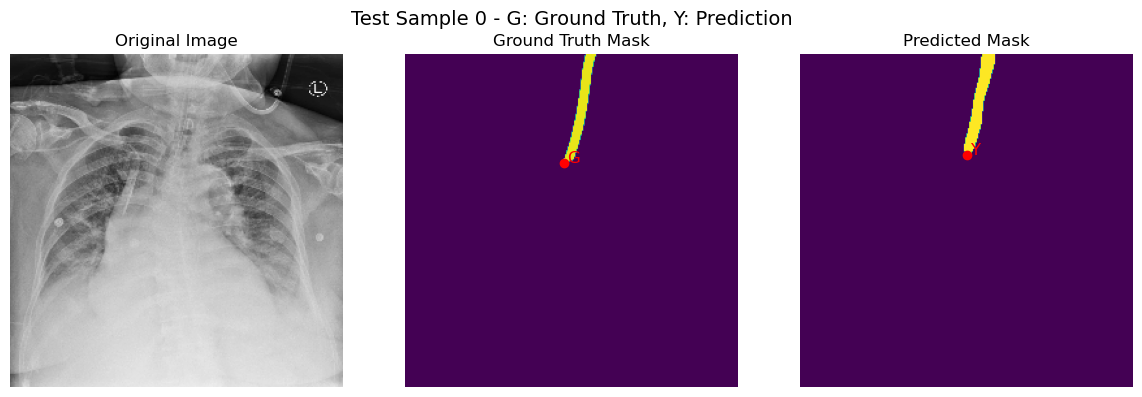

In [10]:
visualize_with_endpoints(0, x_test, y_test, model)

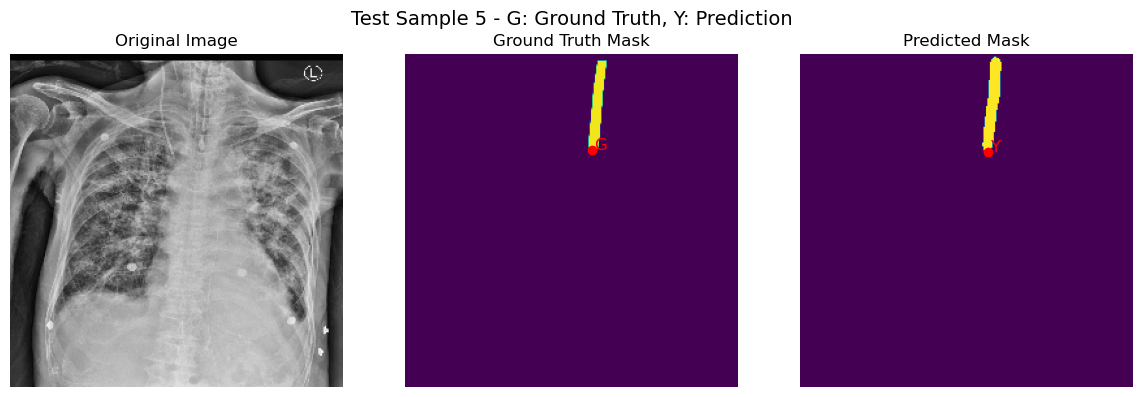

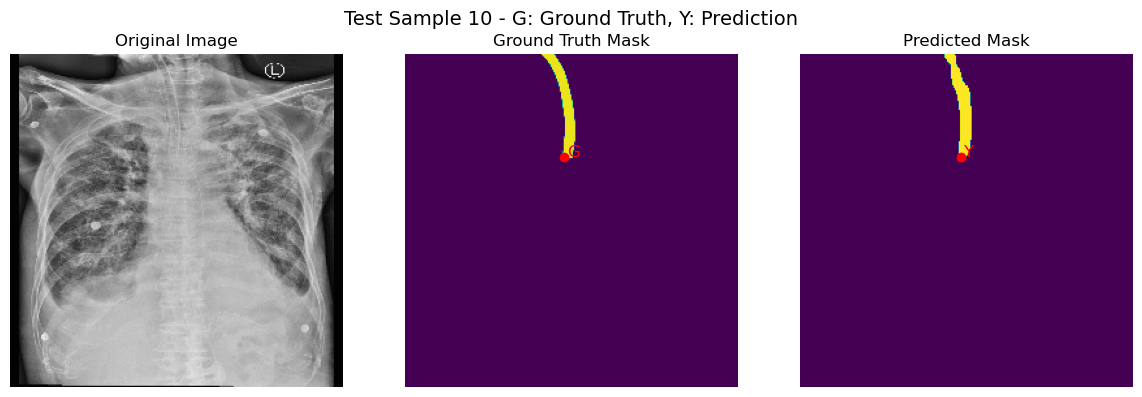

In [11]:
visualize_with_endpoints(5, x_test, y_test, model)
visualize_with_endpoints(10, x_test, y_test, model)